In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf

from sklearn.metrics import accuracy_score

2023-05-05 12:51:40.599597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 12:51:40.923204: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2023-05-05 12:51:40.923224: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-05 12:51:41.920620: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object

In [2]:
from sklearn.model_selection import train_test_split
import cv2 as cv
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [3]:
X_data = []
y_data = []
cont = 0
for letra in os.listdir('/media/emanueloliveira/Dados/SCC0910ComputerVision/Dataset/train'):
    for image in load_images_from_folder(f'/media/emanueloliveira/Dados/SCC0910ComputerVision/Dataset/train/{letra}'):
        X_data.append(image)
        y_data.append(cont)
    cont += 1
    
cont = 0
for letra in os.listdir('/media/emanueloliveira/Dados/SCC0910ComputerVision/Dataset/test'):
    for image in load_images_from_folder(f'/media/emanueloliveira/Dados/SCC0910ComputerVision/Dataset/test/{letra}'):
        X_data.append(image)
        y_data.append(cont)
    cont += 1
    
X_data = np.array(X_data)
y_data = np.array(y_data)

### Testando com VGG

In [4]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

model = apps.VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
model = Model(inputs=model.input, outputs=model.get_layer(index=-1).output)
model.trainable = False

2023-05-05 12:52:24.367813: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/emanueloliveira/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-05-05 12:52:24.367834: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-05 12:52:24.367853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (emanueloliveira-CI581128TBW10): /proc/driver/nvidia/version does not exist
2023-05-05 12:52:24.368261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations,

In [5]:
print("Model output", model.output.shape)

Model output (None, 2, 2, 512)


In [6]:
preds = model.predict(X_data[0:5])

1/1 [==============================] - 0s 224ms/step


In [7]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 512)


In [8]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]

In [9]:
# Extração de features
print("Feature extraction ...")
prediction = np.array(model.predict(X_data))
featuresData = np.reshape(prediction, (prediction.shape[0], Predshape))

print('\tFeatures data shape: ', featuresData.shape)

Feature extraction ...
1377/1377 [==============================] - 248s 180ms/step
	Features data shape:  (44062, 2048)


In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(featuresData)

print('X_reduced shape: ', X_reduced.shape)

X_reduced shape:  (44062, 154)


In [11]:
from sklearn.preprocessing import label_binarize
labels = [i for i in range(0, 20)]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_data, test_size=0.33)

y_train = np.array(label_binarize(y_train, classes=labels))
y_test = np.array(label_binarize(y_test, classes=labels))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [12]:
print(f'training set shape {X_train.shape}')
print(f'testing set shape {X_test.shape}')
print(f'label train set shape {y_train.shape}')
print(f'label test set shape {y_test.shape}')

training set shape (22140, 154)
testing set shape (14541, 154)
label train set shape (22140, 20)
label test set shape (14541, 20)


In [13]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Dense(40, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                6200      
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
Total params: 7,020
Trainable params: 7,020
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
692/692 [==============================] - 2s 2ms/step - loss: 4.0539 - categorical_accuracy: 0.8446 - val_loss: 0.0922 - val_categorical_accuracy: 0.9824
Epoch 2/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0353 - categorical_accuracy: 0.9926 - val_loss: 0.0417 - val_categorical_accuracy: 0.9912
Epoch 3/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0058 - categorical_accuracy: 0.9986 - val_loss: 0.0276 - val_categorical_accuracy: 0.9939
Epoch 4/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0105 - categorical_accuracy: 0.9980 - val_loss: 0.0196 - val_categorical_accuracy: 0.9950
Epoch 5/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0059 - categorical_accuracy: 0.9991 - val_loss: 0.0191 - val_categorical_accuracy: 0.9954
Epoch 6/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0273 - categorical_accuracy: 0.9965 - val_loss: 0.0620 - val_categorical_accuracy: 0.989

Best Validation Loss: 0.0050
Best Validation Accuracy: 0.9995


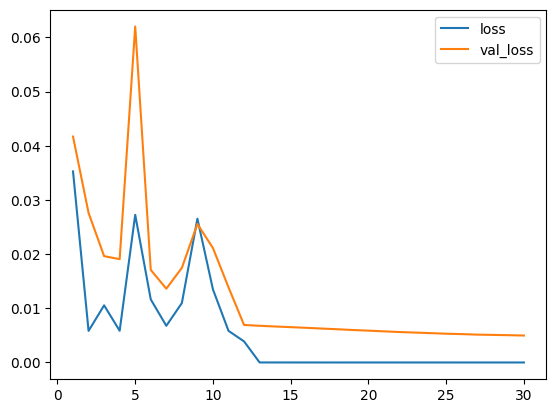

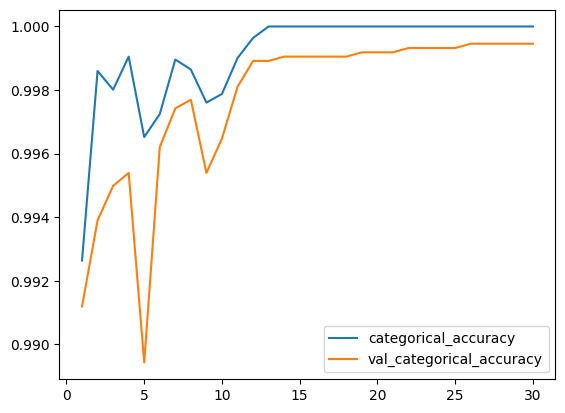

In [16]:
# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))

In [17]:
# Decoding predições e labels de test por hard voting 
argy_test = [np.argmax(i) for i in y_test]
argy_pred = [np.argmax(i) for i in model.predict(X_test)]

455/455 [==============================] - 0s 651us/step


In [18]:
# Resultado nos dados de test

print(f'VGG score on test set: {accuracy_score(argy_test, argy_pred)}')

VGG score on test set: 0.9992435183274878


### Testando com ResNet

In [19]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

model = apps.ResNet50(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
model = Model(inputs=model.input, outputs=model.get_layer(index=-1).output)
model.trainable = False

In [20]:
print("Model output", model.output.shape)

Model output (None, 2, 2, 2048)


In [21]:
preds = model.predict(X_data[0:5])

1/1 [==============================] - 1s 574ms/step


In [22]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 2048)


In [23]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]
print(f"predshape: {Predshape}")

predshape: 8192


In [24]:
# Extração de features
print("Feature extraction ...")
prediction = np.array(model.predict(X_data))
featuresData = np.reshape(prediction, (prediction.shape[0], Predshape))

print('\tFeatures data shape: ', featuresData.shape)

Feature extraction ...
1377/1377 [==============================] - 120s 87ms/step
	Features data shape:  (44062, 8192)


In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(featuresData)

print('X_reduced shape: ', X_reduced.shape)

X_reduced shape:  (44062, 380)


In [26]:
from sklearn.preprocessing import label_binarize
labels = [i for i in range(0, 20)]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_data, test_size=0.33)

y_train = np.array(label_binarize(y_train, classes=labels))
y_test = np.array(label_binarize(y_test, classes=labels))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [27]:
print(f'training set shape {X_train.shape}')
print(f'testing set shape {X_test.shape}')
print(f'label train set shape {y_train.shape}')
print(f'label test set shape {y_test.shape}')

training set shape (22140, 380)
testing set shape (14541, 380)
label train set shape (22140, 20)
label test set shape (14541, 20)


In [28]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Dense(40, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 40)                15240     
                                                                 
 dense_3 (Dense)             (None, 20)                820       
                                                                 
Total params: 16,060
Trainable params: 16,060
Non-trainable params: 0
_________________________________________________________________


In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
692/692 [==============================] - 1s 2ms/step - loss: 0.6447 - categorical_accuracy: 0.8884 - val_loss: 0.0304 - val_categorical_accuracy: 0.9944
Epoch 2/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0134 - categorical_accuracy: 0.9980 - val_loss: 0.0146 - val_categorical_accuracy: 0.9965
Epoch 3/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0047 - categorical_accuracy: 0.9995 - val_loss: 0.0098 - val_categorical_accuracy: 0.9982
Epoch 4/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0018 - categorical_accuracy: 1.0000 - val_loss: 0.0077 - val_categorical_accuracy: 0.9991
Epoch 5/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0010 - categorical_accuracy: 1.0000 - val_loss: 0.0071 - val_categorical_accuracy: 0.9985
Epoch 6/100
692/692 [==============================] - 1s 2ms/step - loss: 6.3060e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0063 - val_categorical_accuracy: 0

Best Validation Loss: 0.0048
Best Validation Accuracy: 0.9995


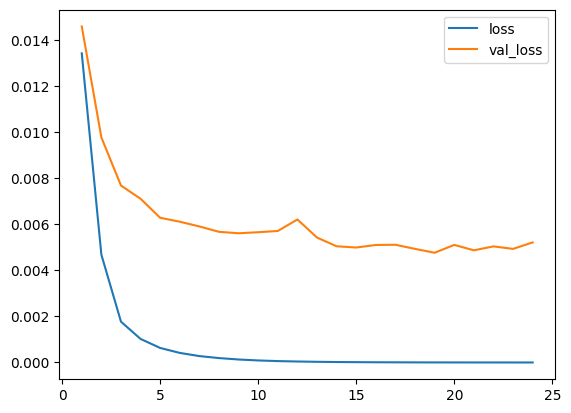

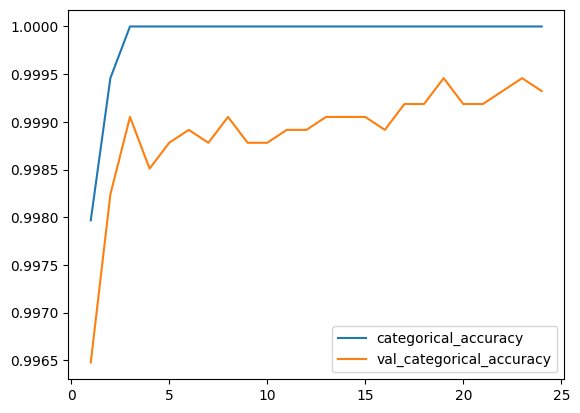

In [31]:
# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))

In [32]:
# Decoding predições e labels de test por hard voting 
argy_test = [np.argmax(i) for i in y_test]
argy_pred = [np.argmax(i) for i in model.predict(X_test)]

455/455 [==============================] - 0s 656us/step


In [33]:
# Resultado nos dados de test

print(f'ResNet score on test set: {accuracy_score(argy_test, argy_pred)}')

ResNet score on test set: 0.9997249157554501


### Testando com EfficientNetB3

In [34]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

model = apps.EfficientNetB3(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
model = Model(inputs=model.input, outputs=model.get_layer(index=-1).output)
model.trainable = False

In [35]:
print("Model output", model.output.shape)

Model output (None, 2, 2, 1536)


In [36]:
preds = model.predict(X_data[0:5])

1/1 [==============================] - 1s 1s/step


In [37]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 1536)


In [38]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]

In [39]:
# Extração de features
print("Feature extraction ...")
prediction = np.array(model.predict(X_data))
featuresData = np.reshape(prediction, (prediction.shape[0], Predshape))

Feature extraction ...
1377/1377 [==============================] - 104s 76ms/step


In [40]:
print('\tFeatures data shape: ', featuresData.shape)

	Features data shape:  (44062, 6144)


In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(featuresData)

In [42]:
print('X_reduced shape: ', X_reduced.shape)

X_reduced shape:  (44062, 208)


In [43]:
from sklearn.preprocessing import label_binarize
labels = [i for i in range(0, 20)]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_data, test_size=0.33)

y_train = np.array(label_binarize(y_train, classes=labels))
y_test = np.array(label_binarize(y_test, classes=labels))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [44]:
print(f'training set shape {X_train.shape}')
print(f'testing set shape {X_test.shape}')
print(f'label train set shape {y_train.shape}')
print(f'label test set shape {y_test.shape}')

training set shape (22140, 208)
testing set shape (14541, 208)
label train set shape (22140, 20)
label test set shape (14541, 20)


In [45]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Dense(40, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 40)                8360      
                                                                 
 dense_5 (Dense)             (None, 20)                820       
                                                                 
Total params: 9,180
Trainable params: 9,180
Non-trainable params: 0
_________________________________________________________________


In [47]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
692/692 [==============================] - 1s 2ms/step - loss: 0.5202 - categorical_accuracy: 0.8804 - val_loss: 0.0662 - val_categorical_accuracy: 0.9917
Epoch 2/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0367 - categorical_accuracy: 0.9956 - val_loss: 0.0217 - val_categorical_accuracy: 0.9974
Epoch 3/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0140 - categorical_accuracy: 0.9989 - val_loss: 0.0103 - val_categorical_accuracy: 0.9995
Epoch 4/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0067 - categorical_accuracy: 0.9997 - val_loss: 0.0065 - val_categorical_accuracy: 0.9993
Epoch 5/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0038 - categorical_accuracy: 0.9998 - val_loss: 0.0042 - val_categorical_accuracy: 0.9997
Epoch 6/100
692/692 [==============================] - 2s 2ms/step - loss: 0.0022 - categorical_accuracy: 1.0000 - val_loss: 0.0031 - val_categorical_accuracy: 0.999

Best Validation Loss: 0.0006
Best Validation Accuracy: 1.0000


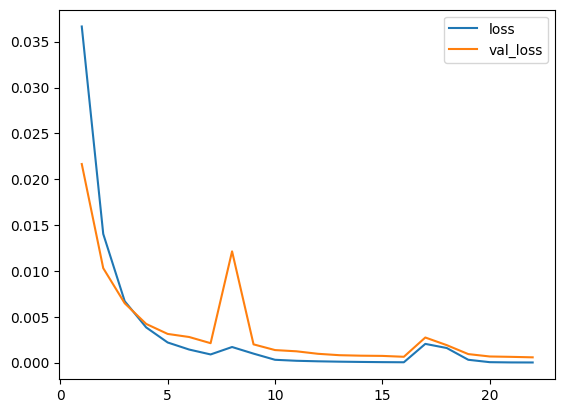

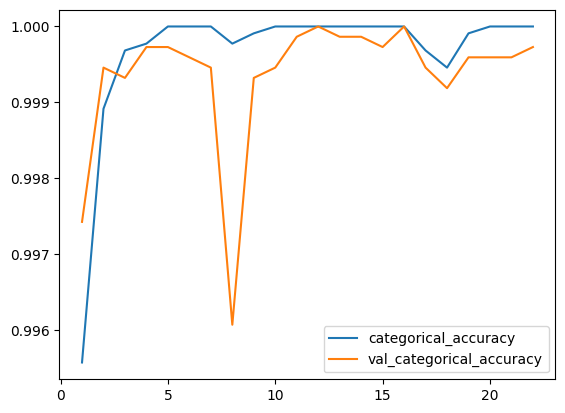

In [48]:
# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))

In [49]:
# Decoding predições e labels de test por hard voting 
argy_test = [np.argmax(i) for i in y_test]
argy_pred = [np.argmax(i) for i in model.predict(X_test)]

455/455 [==============================] - 0s 849us/step


In [50]:
# Resultado nos dados de test

print(f'EfficentNetB3 score on test set: {accuracy_score(argy_test, argy_pred)}')

EfficentNetB3 score on test set: 0.9995873736331752


### Testando com MobileNet

In [51]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

model = apps.MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
model = Model(inputs=model.input, outputs=model.get_layer(index=-1).output)
model.trainable = False

In [52]:
print("Model output", model.output.shape)

Model output (None, 2, 2, 1280)


In [53]:
preds = model.predict(X_data[0:5])

1/1 [==============================] - 0s 488ms/step


In [54]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 1280)


In [55]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]
print(f"predshape: {Predshape}")

predshape: 5120


In [56]:
# Extração de features
print("Feature extraction ...")
prediction = np.array(model.predict(X_data))
featuresData = np.reshape(prediction, (prediction.shape[0], Predshape))

print('\tFeatures data shape: ', featuresData.shape)

Feature extraction ...
1377/1377 [==============================] - 31s 22ms/step
	Features data shape:  (44062, 5120)


In [57]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(featuresData)

print('X_reduced shape: ', X_reduced.shape)

X_reduced shape:  (44062, 243)


In [58]:
from sklearn.preprocessing import label_binarize
labels = [i for i in range(0, 20)]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_data, test_size=0.33)

y_train = np.array(label_binarize(y_train, classes=labels))
y_test = np.array(label_binarize(y_test, classes=labels))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [59]:
print(f'training set shape {X_train.shape}')
print(f'testing set shape {X_test.shape}')
print(f'label train set shape {y_train.shape}')
print(f'label test set shape {y_test.shape}')

training set shape (22140, 243)
testing set shape (14541, 243)
label train set shape (22140, 20)
label test set shape (14541, 20)


In [60]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Dense(40, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [61]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 40)                9760      
                                                                 
 dense_7 (Dense)             (None, 20)                820       
                                                                 
Total params: 10,580
Trainable params: 10,580
Non-trainable params: 0
_________________________________________________________________


In [62]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
692/692 [==============================] - 1s 2ms/step - loss: 1.7090 - categorical_accuracy: 0.5042 - val_loss: 1.0205 - val_categorical_accuracy: 0.6808
Epoch 2/100
692/692 [==============================] - 1s 2ms/step - loss: 0.8273 - categorical_accuracy: 0.7446 - val_loss: 0.7607 - val_categorical_accuracy: 0.7576
Epoch 3/100
692/692 [==============================] - 1s 1ms/step - loss: 0.6322 - categorical_accuracy: 0.7985 - val_loss: 0.6612 - val_categorical_accuracy: 0.7857
Epoch 4/100
692/692 [==============================] - 1s 1ms/step - loss: 0.5343 - categorical_accuracy: 0.8280 - val_loss: 0.6150 - val_categorical_accuracy: 0.7973
Epoch 5/100
692/692 [==============================] - 1s 2ms/step - loss: 0.4686 - categorical_accuracy: 0.8482 - val_loss: 0.5838 - val_categorical_accuracy: 0.8035
Epoch 6/100
692/692 [==============================] - 2s 2ms/step - loss: 0.4227 - categorical_accuracy: 0.8623 - val_loss: 0.5646 - val_categorical_accuracy: 0.810

Best Validation Loss: 0.5564
Best Validation Accuracy: 0.8258


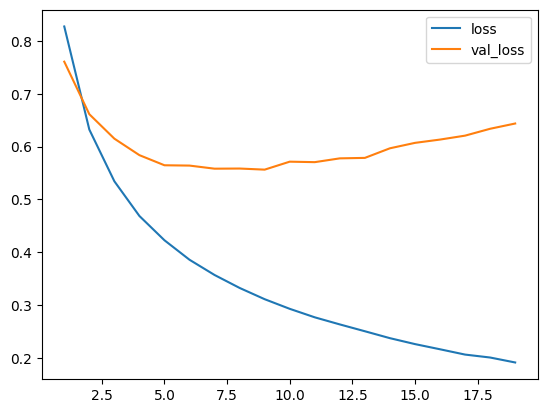

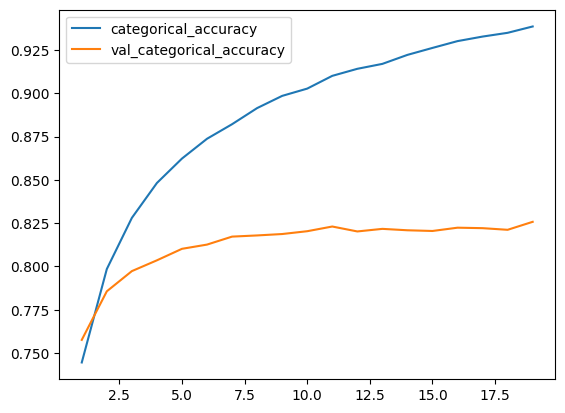

In [63]:
# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))

In [64]:
# Decoding predições e labels de test por hard voting 
argy_test = [np.argmax(i) for i in y_test]
argy_pred = [np.argmax(i) for i in model.predict(X_test)]

455/455 [==============================] - 0s 704us/step


In [65]:
# Resultado nos dados de test

print(f'MobileNet score on test set: {accuracy_score(argy_test, argy_pred)}')

MobileNet score on test set: 0.8229145175710061


### Testando com DenseNet169

In [66]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

model = apps.DenseNet169(include_top=False, weights='imagenet', input_shape=(64, 64, 3)) 
model = Model(inputs=model.input, outputs=model.get_layer(index=-1).output)
model.trainable = False

In [67]:
print("Model output", model.output.shape)

Model output (None, 2, 2, 1664)


In [68]:
preds = model.predict(X_data[0:5])

1/1 [==============================] - 2s 2s/step


In [69]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 1664)


In [70]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]
print(f"predshape: {Predshape}")

predshape: 6656


In [71]:
# Extração de features
print("Feature extraction ...")
prediction = np.array(model.predict(X_data))
featuresData = np.reshape(prediction, (prediction.shape[0], Predshape))

print('\tFeatures data shape: ', featuresData.shape)

Feature extraction ...
1377/1377 [==============================] - 136s 99ms/step
	Features data shape:  (44062, 6656)


In [72]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(featuresData)

print('X_reduced shape: ', X_reduced.shape)

X_reduced shape:  (44062, 68)


In [73]:
from sklearn.preprocessing import label_binarize
labels = [i for i in range(0, 20)]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_data, test_size=0.33)

y_train = np.array(label_binarize(y_train, classes=labels))
y_test = np.array(label_binarize(y_test, classes=labels))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [74]:
print(f'training set shape {X_train.shape}')
print(f'testing set shape {X_test.shape}')
print(f'label train set shape {y_train.shape}')
print(f'label test set shape {y_test.shape}')

training set shape (22140, 68)
testing set shape (14541, 68)
label train set shape (22140, 20)
label test set shape (14541, 20)


In [75]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Dense(40, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [76]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 40)                2760      
                                                                 
 dense_9 (Dense)             (None, 20)                820       
                                                                 
Total params: 3,580
Trainable params: 3,580
Non-trainable params: 0
_________________________________________________________________


In [77]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
692/692 [==============================] - 2s 2ms/step - loss: 7.2659 - categorical_accuracy: 0.6236 - val_loss: 1.0671 - val_categorical_accuracy: 0.8367
Epoch 2/100
692/692 [==============================] - 1s 2ms/step - loss: 0.5992 - categorical_accuracy: 0.8861 - val_loss: 0.4119 - val_categorical_accuracy: 0.9123
Epoch 3/100
692/692 [==============================] - 1s 2ms/step - loss: 0.2799 - categorical_accuracy: 0.9353 - val_loss: 0.2659 - val_categorical_accuracy: 0.9401
Epoch 4/100
692/692 [==============================] - 1s 2ms/step - loss: 0.1643 - categorical_accuracy: 0.9561 - val_loss: 0.1918 - val_categorical_accuracy: 0.9524
Epoch 5/100
692/692 [==============================] - 1s 2ms/step - loss: 0.1098 - categorical_accuracy: 0.9674 - val_loss: 0.1613 - val_categorical_accuracy: 0.9596
Epoch 6/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0869 - categorical_accuracy: 0.9742 - val_loss: 0.1304 - val_categorical_accuracy: 0.969

Epoch 50/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0126 - categorical_accuracy: 0.9970 - val_loss: 0.0905 - val_categorical_accuracy: 0.9897
Epoch 51/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0181 - categorical_accuracy: 0.9970 - val_loss: 0.0758 - val_categorical_accuracy: 0.9894


Best Validation Loss: 0.0577
Best Validation Accuracy: 0.9916


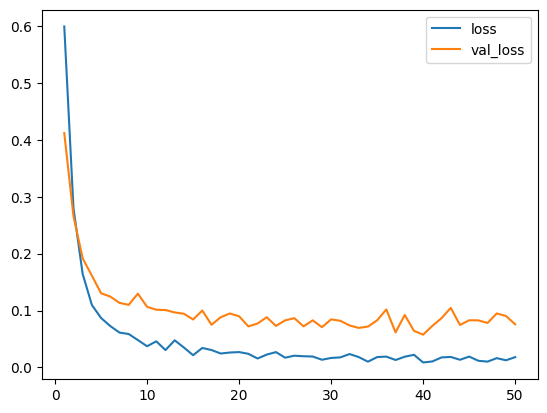

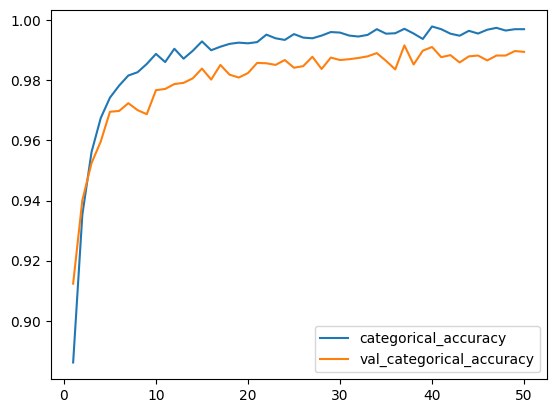

In [78]:
# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))

In [79]:
# Decoding predições e labels de test por hard voting 
argy_test = [np.argmax(i) for i in y_test]
argy_pred = [np.argmax(i) for i in model.predict(X_test)]

455/455 [==============================] - 0s 691us/step


In [80]:
# Resultado nos dados de test

print(f'DenseNet169 score on test set: {accuracy_score(argy_test, argy_pred)}')

DenseNet169 score on test set: 0.9923664122137404


## Resultados:
### VGG: val_loss = 0.0050, val_categorical_accuracy = 99.95%, test_score = 99.92%
### ResNetV2: val_loss = 0.0048, val_categorical_accuracy = 99.95%, test_score = 99.97% 
### EfficientNetB3: val_loss = 0.0045 val_categorical_accuracy = 100%, test_score = 99.96%
### MobileNet: val_loss = 0.4464, val_categoricla_accuracy = 82.58%, test_score = 82.29%
### DenseNet169: val_loss = 0.0577, val_categorical_accuracy = 99,16%, test_score = 99,24%